https://huggingface.co/llava-hf/llava-v1.6-vicuna-13b-hf

In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration, BitsAndBytesConfig
import torch
from PIL import Image
import requests
from pprint import pprint

/home/farzad_rzt/python_env/llava-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "llava-hf/llava-v1.6-vicuna-13b-hf"

**Load the quantized version of the model**
- Quantized model: Requires near `21` GB of GPU memory with the configuration provided in the cell below.
- Full model: Requires near `24` GB of GPU for inferencing

In [3]:
processor = LlavaNextProcessor.from_pretrained(model_id)
quantized = True
if quantized:
        print("===============================================")
        print("Loading the quantized version of the model:")
        print("===============================================")
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16,
        )
        model = LlavaNextForConditionalGeneration.from_pretrained(
    model_id, quantization_config=quantization_config, device_map="auto")
else:
        print("===============================================")
        print("Loading the full version of the model:")
        print("===============================================")
        model = LlavaNextForConditionalGeneration.from_pretrained(
        model_id, 
        # quantization_config=quantization_config,
        device_map="auto")

Loading the quantized version of the model:


Loading checkpoint shards: 100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


In [ ]:
print(model)

LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear4bit(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
            

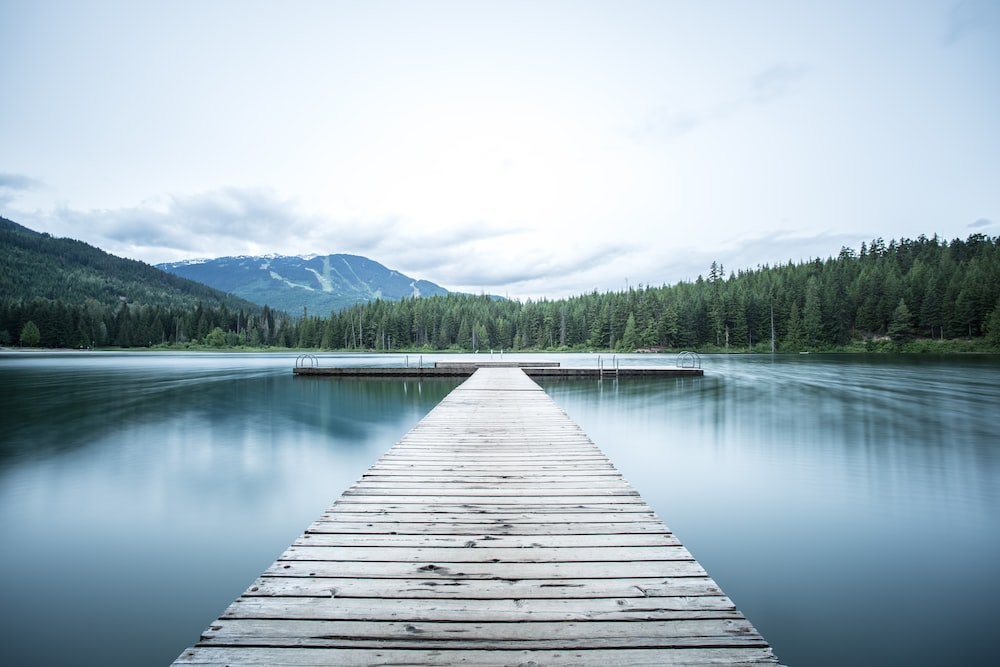

In [ ]:
url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get("https://llava-vl.github.io/static/images/view.jpg", stream=True).raw)
image

In [ ]:
prompt = "What are the things I should be cautious about when I visit this place? What should I bring with me?"
max_output_token = 500
prompt = f"[INST] <image>\n{prompt} [/INST]"
inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")
output = model.generate(**inputs, max_new_tokens=max_output_token)
response = processor.decode(output[0], skip_special_tokens=True)
pprint(response)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


('[INST] \n'
 'What are the things I should be cautious about when I visit this place? What '
 'should I bring with me? [/INST]')


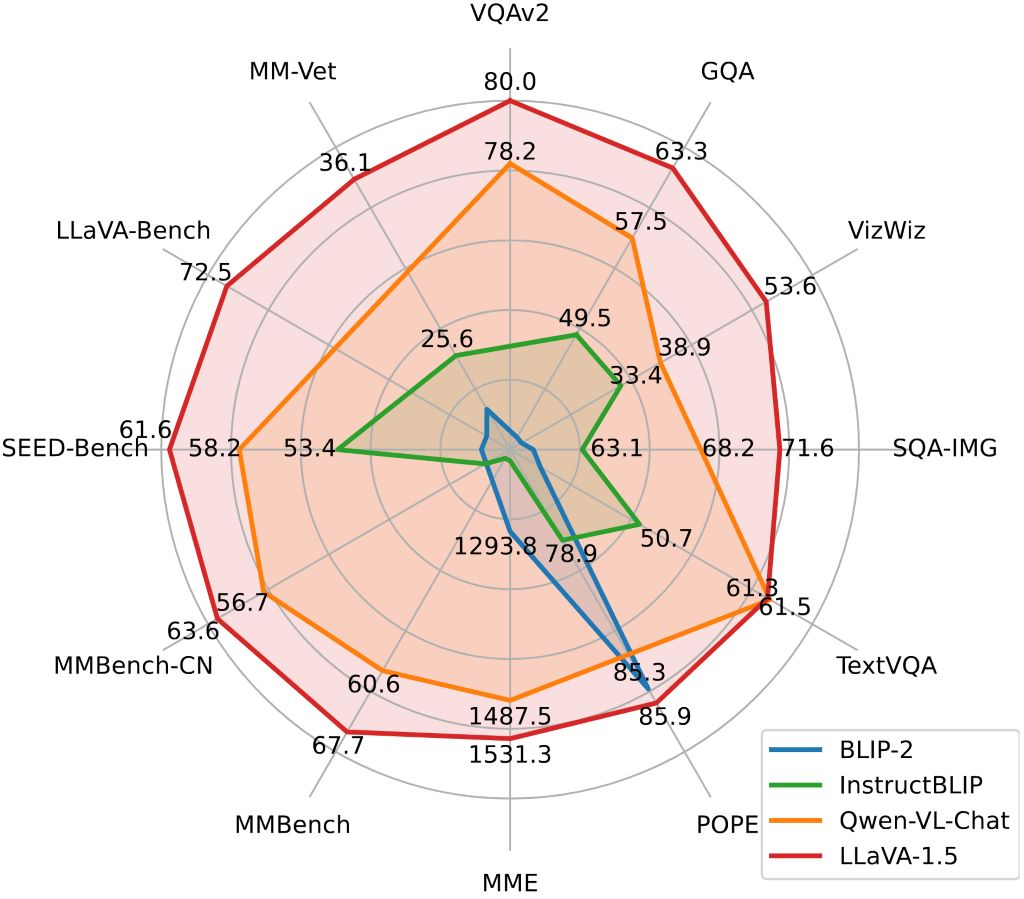

In [ ]:
# prepare image and text prompt, using the appropriate prompt template
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
# Define a chat histiry and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(prompt, image, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))

USER: 
What is shown in this image? ASSISTANT: The image appears to be a radar chart, also known as a spider chart or a star chart, which is a graphical method of displaying multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point.

In this particular chart, there are several axes labeled with different acronyms and values, which likely represent different metrics or variables being compared. The axes are labeled with acronym
